# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [ ]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets # torchvision.datasets을 호출함으로서 CIFAR-10 dataset을 사용할 수 있습니다.

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [ ]:
transforms_cifar10 = transforms.Compose([ #여러 가지 이미지 변환 작업을 연속적으로 적용할 수 있게 해주는 PyTorch 함수입니다.
                                  transforms.Resize((32, 32)), #cifar10 dataset 내 image의 크기를 32*32로 조정합니다. CIFAR-10 데이터셋의 이미지 크기는 이미 32x32이므로 이 변환은 필요 없습니다.
                                  transforms.ToTensor(), #로드한 이미지를 PyTorch 텐서로 변환합니다. 이 변환작업은 이미지의 픽셀 값을 [0, 255]에서 [0.0, 1.0] 범위로 정규화합니다.
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #각 채널(R, G, B)의 평균을 0.5, 표준편차를 0.5로 설정하여 정규화합니다.
                                    #정규화된 결과는 [0, 1] 범위에서 [-1, 1] 범위로 변환됩니다.
                                 ])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
#CIFAR-10 데이터셋의 훈련 데이터를 로드합니다. root='./data': 데이터셋을 저장할 경로입니다.
#train=True: 훈련 데이터를 로드하겠다는 의미입니다.
#download=True: 데이터셋이 로컬에 없으면 인터넷에서 다운로드합니다.
#transform=transforms_cifar10: 앞서 정의한 이미지 변환을 적용합니다.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
#데이터셋을 로드하고 미니배치로 분할하는 PyTorch의 DataLoader입니다.
#trainset: 로드할 데이터셋입니다.
#batch_size=4: 미니배치 크기를 4로 설정합니다.
#shuffle=True: 에폭마다 데이터를 섞습니다.
#num_workers=2: 데이터 로딩을 위해 사용할 병렬 프로세스 수입니다.

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
#CIFAR-10 데이터셋의 테스트 데이터를 로드합니다.
#train=False: 테스트 데이터를 로드하겠다는 의미입니다.
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
#테스트 데이터셋을 로드하고 미니배치로 분할하는 DataLoader입니다.
#shuffle=False: 테스트 데이터는 섞지 않습니다.

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
#CIFAR-10 데이터셋의 클래스(라벨) 이름입니다. 각 클래스는 10가지로 구성되어 있습니다.

100%|██████████| 170498071/170498071 [00:03<00:00, 48324235.69it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


truck  deer  ship   car


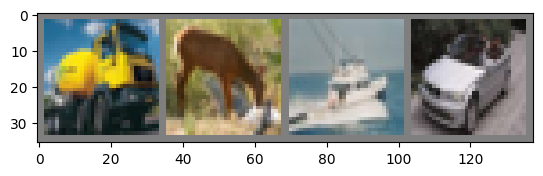

In [ ]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
#def imshow(img): 이미지를 시각화하는 함수입니다.
#img = img / 2 + 0.5: 앞서 정규화된 이미지를 역정규화하여 [0, 1] 범위로 변환합니다. CIFAR-10 데이터셋 이미지는 정규화되어 [-1, 1] 범위에 있습니다.
#npimg = img.numpy(): PyTorch 텐서를 NumPy 배열로 변환합니다.
#plt.imshow(np.transpose(npimg, (1, 2, 0))): 이미지를 시각화합니다. np.transpose(npimg, (1, 2, 0))는 이미지의 채널 순서를 변경하여 (높이, 너비, 채널) 형식으로 변환합니다.

dataiter = iter(trainloader)
#dataiter = iter(trainloader): 훈련 데이터셋을 반복할 수 있는 이터레이터를 생성합니다.
###iteration은 전체 데이터를 학습하는 1번의 epoch 중 설정한 batch 사이즈에 따라 epoch 내에서 총 dataset/batch size 번 학습하는 수 입니다.
imgs, labels = next(dataiter)
#imgs, labels = next(dataiter): 이터레이터에서 배치를 하나 가져옵니다. imgs는 이미지들로, labels는 해당 이미지들의 레이블들입니다.
imshow(torchvision.utils.make_grid(imgs))
#imshow(torchvision.utils.make_grid(imgs)): torchvision.utils.make_grid는 여러 이미지를 격자로 배치한 이미지를 만듭니다. imshow 함수는 이 격자 이미지를 시각화합니다.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
#print(' '.join('%5s' % classes[labels[j]] for j in range(4))): 현재 배치에 있는 이미지들의 레이블을 출력합니다.
#' '.join(...): 레이블들을 공백으로 구분하여 하나의 문자열로 만듭니다.
#'%5s' % classes[labels[j]]: 각 레이블을 5칸의 문자열로 형식화합니다.
#for j in range(4): 배치에서 처음 4개의 이미지의 레이블을 가져옵니다.

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [ ]:
# Model

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__() #super(SimpleNet, self).__init__(): 부모 클래스 nn.Module의 초기화 메서드를 호출합니다.
        self.conv1 = nn.Conv2d(3, 6, 5) #첫 번째 합성곱 층입니다. 3개의 입력 채널(RGB 이미지), 6개의 출력 채널, 5x5의 커널 크기를 사용합니다.
        #(input channel, output channel, kernel_size, stride, padding) 에서 stride와 padding은 생략 가능합니다.
        self.pool = nn.MaxPool2d(2, 2) #최대 풀링 층입니다. 2x2 풀링 창을 사용합니다.
        self.conv2 = nn.Conv2d(6, 16, 5) #두 번째 합성곱 층입니다. 6개의 입력 채널, 16개의 출력 채널, 5x5의 커널 크기를 사용합니다.

        self.fc1 = nn.Linear(16 * 5 * 5, 120) #첫 번째 완전 연결 층입니다. 입력 크기는 16 * 5 * 5이고 출력 크기는 120입니다.
        self.fc2 = nn.Linear(120, 84) #두 번째 완전 연결 층입니다. 입력 크기는 120이고 출력 크기는 84입니다.
        self.fc3 = nn.Linear(84, 10) #세 번째 완전 연결 층입니다. 입력 크기는 84이고 출력 크기는 10입니다. CIFAR-10 데이터셋의 10개의 클래스를 예측합니다.

    def forward(self, x): #순전파(forward) 메서드입니다. 입력 텐서 x를 받아 출력 텐서를 반환합니다.
        x = self.pool(F.relu(self.conv1(x))) #첫 번째 합성곱 층을 적용한 후, ReLU 활성화 함수와 최대 풀링을 적용합니다.
        x = self.pool(F.relu(self.conv2(x))) #두 번째 합성곱 층을 적용한 후, ReLU 활성화 함수와 최대 풀링을 적용합니다.
        x = x.view(-1, 16 * 5 * 5) #텐서를 일렬로 펼칩니다. 이 단계는 합성곱 층에서 완전 연결 층으로 넘어갈 때 필요합니다.
        x = F.relu(self.fc1(x)) #첫 번째 완전 연결 층을 적용한 후, ReLU 활성화 함수를 적용합니다.
        x = F.relu(self.fc2(x)) #두 번째 완전 연결 층을 적용한 후, ReLU 활성화 함수를 적용합니다.
        x = self.fc3(x) #세 번째 완전 연결 층을 적용하여 최종 출력을 얻습니다.
        return x


net = SimpleNet().to(device) #SimpleNet 클래스의 인스턴스를 생성합니다. 모델을 지정된 장치(device)로 이동시킵니다. 일반적으로 이는 CPU 또는 GPU를 의미합니다.

#SimpleNet 모델은 두 개의 합성곱 층과 세 개의 완전 연결 층으로 구성됩니다.
#각 합성곱 층 뒤에는 ReLU 활성화 함수와 최대 풀링 층이 있고, 완전 연결 층은 ReLU 활성화 함수를 사용합니다. 모델의 인스턴스를 생성하고 지정된 장치로 이동시킵니다.

In [ ]:
# VGG Model

cfg = {'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']}
#cfg: VGG11 모델의 구조를 정의하는 설정입니다. 숫자는 각 합성곱 층의 출력 채널 수를 의미하고, 'M'은 최대 풀링(Max Pooling) 층을 의미합니다.
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = self.make_layers(cfg['VGG11'])
        self.classifier = nn.Linear(512, 10)
#super(VGG11, self).__init__(): 부모 클래스 nn.Module의 초기화 메서드를 호출합니다.
#self.features = self.make_layers(cfg['VGG11']): VGG11의 특징 추출기 부분을 정의합니다. make_layers 메서드를 사용하여 cfg['VGG11']에 정의된 구조로 레이어를 생성합니다.
#self.classifier = nn.Linear(512, 10): 분류기를 정의합니다. 512개의 입력 특징을 받아 10개의 출력 클래스를 생성합니다(CIFAR-10 데이터셋의 10개 클래스).
    def make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
#def make_layers(self, cfg): cfg에 정의된 구조에 따라 레이어를 생성합니다.
    #layers = []: 레이어를 담을 리스트를 초기화합니다.
    #in_channels = 3: 초기 입력 채널 수를 3으로 설정합니다(RGB 이미지).
    #for x in cfg: cfg 리스트를 순회하며 레이어를 생성합니다.
        #if x == 'M': 'M'은 최대 풀링(Max Pooling) 층을 의미합니다.
             #layers += [nn.MaxPool2d(kernel_size=2, stride=2)]: 2x2 최대 풀링 층을 추가합니다.
        #else: 숫자는 합성곱 층의 출력 채널 수를 의미합니다.
             #layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1)]: 합성곱 층을 추가합니다.
                        #nn.BatchNorm2d(x): 배치 정규화 층을 추가합니다.
                        #nn.ReLU(inplace=True): ReLU 활성화 함수를 추가합니다.
             #in_channels = x: 출력 채널 수를 업데이트합니다.
    #layers += [nn.AvgPool2d(kernel_size=1, stride=1)]: 평균 풀링 층을 추가합니다.
    #return nn.Sequential(*layers): 레이어 리스트를 nn.Sequential로 묶어 반환합니다.

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
#def forward(self, x): 순전파(forward) 메서드입니다.
    #out = self.features(x): 입력 x에 대해 특징 추출기 부분을 적용합니다.
    #out = out.view(out.size(0), -1): 텐서를 일렬로 펼칩니다. 배치 크기를 유지하고 나머지 차원들을 평탄화합니다.
    #out = self.classifier(out): 펼쳐진 텐서에 대해 분류기를 적용합니다.
    #return out: 최종 출력을 반환합니다.

net = VGG11().to(device)
#net = VGG11(): VGG11 클래스의 인스턴스를 생성합니다.
#.to(device): 모델을 지정된 장치(device)로 이동시킵니다. 일반적으로 이는 CPU 또는 GPU를 의미합니다.

#이 코드는 VGG11 모델을 정의하고 초기화합니다. cfg를 사용하여 모델의 구조를 정의하고, make_layers 메서드를 통해 합성곱 층과 풀링 층을 생성합니다.
#forward 메서드는 입력 데이터를 특징 추출기와 분류기를 통해 순전파하여 최종 출력을 생성합니다. 모델의 인스턴스를 생성하고 지정된 장치로 이동시킵니다.

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
# Loss function and optimizer
#손실 함수 (Loss Function):
criterion = nn.CrossEntropyLoss() #criterion = nn.CrossEntropyLoss(): 손실 함수로 교차 엔트로피 손실을 사용해 모델의 출력과 실제 레이블 간의 차이를 계산하여 손실 값을 반환합니다.

#최적화 알고리즘 (Optimizer):
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) #최적화 알고리즘으로 Adam 옵티마이저를 사용합니다.
#net.parameters(): 모델 net의 학습 가능한 파라미터들을 옵티마이저에 전달합니다.
#lr=0.001: 학습률(learning rate)을 0.001로 설정합니다. 학습률은 각 파라미터 업데이트의 크기를 결정합니다.

#학습률 스케줄러 (Learning Rate Scheduler):
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) #학습률 스케줄러를 설정합니다.
torch.optim.lr_scheduler.StepLR: 일정한 에폭 간격(step size)마다 학습률을 조정하는 학습률 스케줄러입니다.

#optimizer: 학습률을 조정할 옵티마이저를 지정합니다.
#step_size=10: 매 10 에폭마다 학습률을 조정합니다.
#gamma=0.1: 학습률을 0.1배로 감소시킵니다. 예를 들어, 초기 학습률이 0.001이었다면, 10 에폭 후에는 0.0001이 됩니다. 학습이 진행될 때마다 학습률을 점진적으로 줄여 모델이 더 세밀하게 학습할 수 있도록 합니다.

# **Train the network**

Train your own network using the above loss function and optimizer.

In [ ]:
# Train the model
#에폭 수 설정:
epochs = 5  # number of epochs 에폭은 데이터셋 전체를 한 번 학습하는 주기를 의미합니다.

#에폭 루프:
for epoch in range(epochs): #에폭 루프: 설정된 에폭 수만큼 훈련을 반복합니다.

    loss_tmp = 0.0 #loss_tmp = 0.0: 미니 배치의 손실 값을 누적할 변수입니다.
    epoch_loss = 0.0 #epoch_loss = 0.0: 전체 에폭 동안의 손실 값을 누적할 변수입니다.

#미니 배치 루프:
    for i, data in enumerate(trainloader, start=0):
   #for i, data in enumerate(trainloader, start=0): trainloader에서 데이터를 하나씩 가져와 반복합니다. i는 반복 횟수(인덱스)를 나타내고, data는 배치 데이터를 나타냅니다.
   #trainloader에서 배치 단위로 데이터를 가져와 학습합니다.
        # Load the data
        inputs, labels = data #data에서 입력 데이터와 레이블을 분리합니다.
        inputs = inputs.to(device) #입력 데이터를 지정된 장치(device, 보통 GPU)로 이동시킵니다.
        labels = labels.to(device) #레이블 데이터를 지정된 장치(device)로 이동시킵니다.

        # Estimate the output using the network
        outputs = net(inputs) #네트워크 net을 사용하여 입력 데이터에 대한 예측값을 계산합니다.

        # Calculate the loss between the output of the network and label
        loss = criterion(outputs, labels) #loss = criterion(outputs, labels): 예측값(outputs)과 실제 레이블(labels) 간의 손실을 계산합니다. 여기서는 교차 엔트로피 손실을 사용합니다.

        # Optimize the network
        optimizer.zero_grad() #optimizer.zero_grad(): 이전 미니 배치의 그래디언트를 초기화합니다.
        loss.backward() #loss.backward(): 역전파(backpropagation)를 통해 그래디언트를 계산합니다.
        optimizer.step() #optimizer.step(): 옵티마이저를 사용하여 파라미터를 업데이트합니다.

        loss_tmp += loss.data #현재 배치의 손실을 loss_tmp에 누적합니다.
        epoch_loss += loss.data #현재 배치의 손실을 epoch_loss에 누적합니다.

        if i % 5000 == 4999:    # 매 5000번째 미니 배치마다 손실을 출력합니다.
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' % #현재 에폭과 미니 배치 손실을 출력합니다.
                  (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0 #loss_tmp를 초기화합니다.

#학습률 스케줄러 업데이트:
    # Update the learning rate according to the learnig rate scheduler
    scheduler.step() #에폭이 끝날 때마다 학습률 스케줄러를 업데이트합니다.

#에폭 손실 출력:
    # Print the epoch loss
    print('[Epoch - %d] Loss: %.3f' %(epoch + 1, epoch_loss / (i+1))) #현재 에폭의 평균 손실을 출력합니다.

#훈련 완료 메시지 출력:
print('Finished Training')

[Epoch - 1, Iteration -  5000] Loss: 1.687


KeyboardInterrupt: 

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship   car  ship


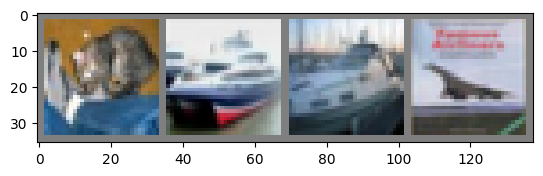

In [ ]:
# Test the trained model with sample
#테스트 데이터 준비:
dataiter_test = iter(testloader) #testloader의 반복자(iterator)를 생성합니다.
img_test, labels_test = next(dataiter_test) # testloader에서 한 배치의 테스트 데이터를 가져옵니다. img_test는 이미지 배치이고, labels_test는 해당 배치의 레이블입니다.

imshow(torchvision.utils.make_grid(img_test)) #배치에서 가져온 이미지를 그리드 형식으로 보여줍니다. imshow 함수는 이미지를 시각화합니다.
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4))) # 실제 레이블(정답)을 출력합니다. classes 리스트를 사용하여 숫자 레이블을 문자로 변환합니다.

#데이터 장치 이동:
img_test = img_test.to(device) #테스트 이미지를 지정된 장치(device)로 이동시킵니다.
labels_test = labels_test.to(device) #테스트 레이블을 지정된 장치(device)로 이동시킵니다.

#모델 예측:
outputs_test = net(img_test) #모델 net을 사용하여 테스트 이미지에 대한 예측값을 계산합니다.
_, predicted = torch.max(outputs_test.data, 1) #예측값에서 최대값의 인덱스를 가져옵니다. 이 인덱스가 예측된 클래스입니다.
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
#모델이 예측한 레이블을 출력합니다. classes 리스트를 사용하여 숫자 레이블을 문자로 변환합니다.

In [ ]:
# Test the trained model with overall test dataset

#변수 초기화:
correct = 0 #정확히 예측한 샘플 수를 저장하는 변수입니다.
total = 0 #전체 샘플 수를 저장하는 변수입니다.

#테스트 데이터 루프:
for data in testloader: #testloader에서 배치 단위로 데이터를 반복합니다.
    # Load the data
    inputs_test, labels_test = data #data에서 입력 이미지와 레이블을 분리합니다.
    inputs_test = inputs_test.to(device) #입력 이미지를 지정된 장치(device)로 이동시킵니다.
    labels_test = labels_test.to(device) #레이블을 지정된 장치(device)로 이동시킵니다.

    # Estimate the output using the trained network
    outputs_test = net(inputs_test) #네트워크 net을 사용하여 입력 이미지에 대한 예측값을 계산합니다.
    _, predicted = torch.max(outputs_test.data, 1) #예측값에서 최대값의 인덱스를 가져옵니다. 이 인덱스가 예측된 클래스입니다.

#정확도 계산:
    # Calculate the accuracy
    total += labels.size(0) #현재 배치의 전체 샘플 수를 total에 추가합니다.
    correct += (predicted == labels).sum() #현재 배치에서 정확히 예측한 샘플 수를 correct에 추가합니다. item() 메서드를 사용하여 텐서에서 값을 추출합니다.

#최종 정확도 출력:
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total)) #테스트 데이터셋에 대한 모델의 최종 정확도를 출력합니다.


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 12 %

Accuracy of the network on the 10,000 test images: 8 %
